# MNIST - Activation Correlations

Training simple 3-layer CNN and computing correlation between activation of samples in each layer (on MNIST data set).

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import collections


## Settings

In [2]:
batch_size = 256
batch_size_test = 1000
ngpu = 0
epochs = 10

In [3]:
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

## Loading data

In [4]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])

dataset_train = torchvision.datasets.MNIST(
    root="./data", train=True, download=True, transform=transform
)
dataset_test = torchvision.datasets.MNIST(
    root="./data", train=False, download=True, transform=transform
)

loader_train = torch.utils.data.DataLoader(
    dataset_train, batch_size=batch_size, shuffle=True
)
loader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=batch_size_test, shuffle=True
)


Using downloaded and verified file: ./data/MNIST/raw/train-images-idx3-ubyte.gz
Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz
Using downloaded and verified file: ./data/MNIST/raw/train-labels-idx1-ubyte.gz
Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz
Using downloaded and verified file: ./data/MNIST/raw/t10k-images-idx3-ubyte.gz
Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz
Using downloaded and verified file: ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz
Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz
Processing...
Done!


/Users/jonasbernhard/opt/miniconda3/envs/pytorch/lib/python3.9/site-packages/torchvision/datasets/mnist.py:335: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /Users/distiller/project/conda/conda-bld/pytorch_1631631181957/work/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed).view(length, num_rows, num_cols)


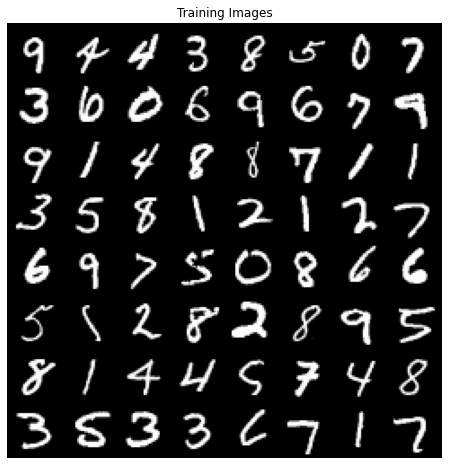

In [5]:
# Plot some training images
real_batch = next(iter(loader_train))
plt.figure(figsize=(8, 8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(
    np.transpose(
        torchvision.utils.make_grid(
            real_batch[0].to(device)[:64], padding=2, normalize=True
        ).cpu(),
        (1, 2, 0),
    )
)


## Implementation

Defining very simple CNN with three convolutional layers and two fully connected layers with max pooling after the last convolutional layer. The activities are recorded after applying the activation function for each convolutional layer.

### Model

In [6]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 1, 3, 1)
        self.conv2 = nn.Conv2d(1, 1, 3, 1)
        self.conv3 = nn.Conv2d(1, 1, 3, 1)
        self.fc1 = nn.Linear(121, 64)
        self.fc2 = nn.Linear(64, 10)

        self.activations = collections.defaultdict(list)

    def forward(self, x, record_activations = False):
        x = self.conv1(x)
        x = F.relu(x)
        if record_activations:
            self.activations["relu1"].append(x)
        x = self.conv2(x)
        x = F.relu(x)
        if record_activations:
            self.activations["relu2"].append(x)
        x = self.conv3(x)
        x = F.relu(x)
        if record_activations:
            self.activations["relu3"].append(x)
        x = F.max_pool2d(x, 2)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output

    def reset_recorded_activations(self):
        self.activations = collections.defaultdict(list)

### Training

In [7]:
def train(model, device, loader_train, optimizer, epoch):
    model.train()
    train_loss = 0
    for batch_idx, (data, target) in enumerate(loader_train):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * len(data)
        if batch_idx % 100 == 0:
            print(
                "Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}".format(
                    epoch,
                    batch_idx * len(data),
                    len(loader_train.dataset),
                    100.0 * batch_idx / len(loader_train),
                    loss.item(),
                )
            )
    train_loss /= len(loader_train.dataset)
    return train_loss


def test(model, device, loader_test):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in loader_test:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(
                output, target, reduction="sum"
            ).item()  # sum up batch loss
            pred = output.argmax(
                dim=1, keepdim=True
            )  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(loader_test.dataset)

    print(
        "\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n".format(
            test_loss,
            correct,
            len(loader_test.dataset),
            100.0 * correct / len(loader_test.dataset),
        )
    )
    return test_loss


In [8]:
model = Net().to(device)
optimizer = torch.optim.Adadelta(model.parameters(), lr=1.0)

train_loss_history = []
test_loss_history = []

scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.7)
for epoch in range(1, epochs + 1):
    train_loss = train(model, device, loader_train, optimizer, epoch)
    test_loss = test(model, device, loader_test)

    train_loss_history += [train_loss]
    test_loss_history += [test_loss]

    scheduler.step()


Train Epoch: 1 [0/60000 (0%)]	Loss: 2.297246
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.316782
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.292625

Test set: Average loss: 0.2963, Accuracy: 9041/10000 (90%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.245292
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.154104
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.140796

Test set: Average loss: 0.1645, Accuracy: 9498/10000 (95%)

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.171540
Train Epoch: 3 [25600/60000 (43%)]	Loss: 0.170965
Train Epoch: 3 [51200/60000 (85%)]	Loss: 0.110988

Test set: Average loss: 0.1383, Accuracy: 9592/10000 (96%)

Train Epoch: 4 [0/60000 (0%)]	Loss: 0.109409
Train Epoch: 4 [25600/60000 (43%)]	Loss: 0.092428
Train Epoch: 4 [51200/60000 (85%)]	Loss: 0.083820

Test set: Average loss: 0.1179, Accuracy: 9658/10000 (97%)

Train Epoch: 5 [0/60000 (0%)]	Loss: 0.114183
Train Epoch: 5 [25600/60000 (43%)]	Loss: 0.118593
Train Epoch: 5 [51200/60000 (85%)]	Loss: 0.160957

Test set: Average loss: 0.1126

Plotting training and validation loss over epochs (seeing that there is no massive overfitting happening):

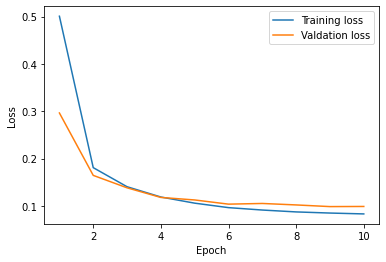

In [9]:
fig, ax = plt.subplots()

x = range(1, epochs + 1)

ax.plot(x, train_loss_history, label="Training loss")
ax.plot(x, test_loss_history, label="Valdation loss")

ax.set_xlabel("Epoch")
ax.set_ylabel("Loss")
ax.legend()

## Correlation between samples in each layer

In [10]:
# Loading batch of size {batch_size_test}
real_batch = next(iter(loader_test))
data, targets = real_batch

# Running classification for batch and recording activities
output = model(data, record_activations=True)
pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability


For each recorded layer, calculate the correlation between the samples and plotting them as a heatmap:

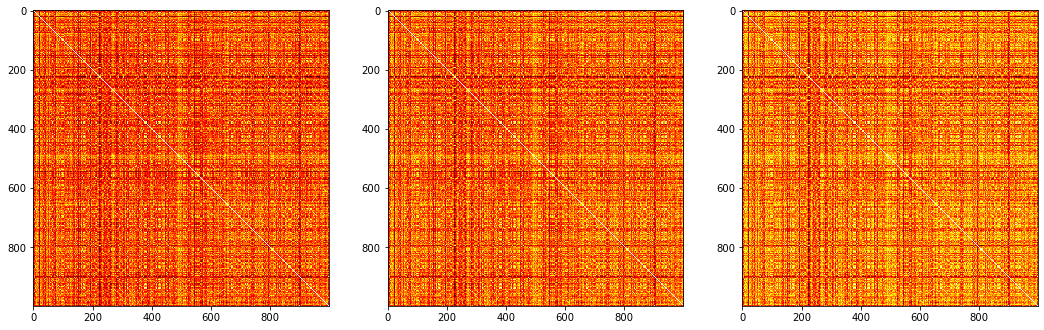

In [11]:
activation_layers = ["relu1", "relu2", "relu3"]

fig, axes = plt.subplots(ncols=len(activation_layers), figsize=(18, 6))

for i in range(len(activation_layers)):
    layer = activation_layers[i]
    activations = model.activations[layer][0].flatten(1)

    corr = np.corrcoef(activations.detach())

    axes.flat[i].imshow(corr, cmap='hot', interpolation='nearest')

Sorting the samples by their labels gives a clearer picture of the correlations. We see that images of the same digit (around the diagonal) have a much higher correlation in their activation compared to other digits.

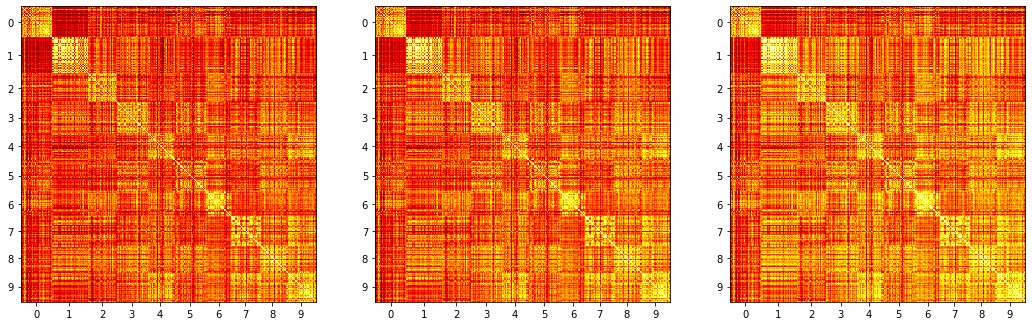

In [12]:
activation_layers = ["relu1", "relu2", "relu3"]

fig, axes = plt.subplots(ncols=len(activation_layers), figsize=(18, 6))

for i in range(len(activation_layers)):
    ax = axes.flat[i]

    layer = activation_layers[i]
    activations = model.activations[layer][0].flatten(1)
    # Sorting activations by their label
    activations = activations[[targets.argsort()]]

    targets.sort()

    corr = np.corrcoef(activations.detach())

    # Calculate axis tick locations
    axis_ticks = []
    digits = range(10)
    for digit in digits:
        # Find indices of digit in sorted targets
        digit_indices = (targets.sort().values == digit).nonzero(as_tuple=True)[0]
        axis_ticks += [digit_indices[0].item() + len(digit_indices) // 2]

    ax.imshow(corr, cmap='hot', interpolation='nearest')
    ax.set_xticks(axis_ticks)
    ax.set_xticklabels(digits)
    ax.set_yticks(axis_ticks)
    ax.set_yticklabels(digits)